# $D^0\to K^0_S\pi^+\pi^-$ from Jordi

Let's code the amplitude model as written by Jordi, such that we could use AmpliTF and TFA functions to generate the samples.

In [1]:
# Import AmpliTF modules
import amplitf.interface as atfi
import amplitf.kinematics as atfk
import amplitf.dynamics as atfd
import amplitf.likelihood as atfl
from amplitf.phasespace.dalitz_phasespace import DalitzPhaseSpace

# Import TFA modules
import tfa.toymc as tft
import tfa.plotting as tfp
import tfa.optimisation as tfo

2025-06-03 09:27:49.166678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748935669.186933  882545 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748935669.193029  882545 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748935669.208379  882545 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748935669.208395  882545 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748935669.208397  882545 computation_placer.cc:177] computation placer alr

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


I0000 00:00:1748935671.570043  882545 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46761 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:41:00.0, compute capability: 8.6


Useful functions

In [2]:
import matplotlib.pyplot as plt
def plot_data(data):
    tfp.set_lhcb_style(size=12, usetex=False)  # Adjust plotting style for LHCb papers
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))  # Single subplot on the figure

    # Plot 1D histogram from the toy MC sample
    tfp.plot_distr2d(
        data[:, 0],
        data[:, 1],
        bins=(50, 50),
        ranges=((0.3, 3.1), (0.3, 3.1)),
        fig=fig,
        ax=ax[0, 0],
        labels=(r"$m^2(K_S^0\pi^+)$", r"$m^2(K_S^0\pi^-)$"),
        units=("MeV$^2$", "MeV$^2$"),
        log=True,
    )

    tfp.plot_distr1d(
        data[:, 0],
        bins=50,
        range=(0.3, 3.1),
        ax=ax[0, 1],
        label=r"$m^2(K_S^0\pi^+)$",
        units="MeV$^2$",
    )

    tfp.plot_distr1d(
        data[:, 1],
        bins=50,
        range=(0.3, 3.1),
        ax=ax[1, 0],
        label=r"$m^2(K_S^0\pi^-)$",
        units="MeV$^2$",
    )

    tfp.plot_distr1d(
        phsp.m2ac(data),
        bins=50,
        range=(0.05, 1.9),
        ax=ax[1, 1],
        label=r"$m^2(\pi^+\pi^-)$",
        units="MeV$^2$",
    )

    # Show the plot
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

    return fig, ax

Set the number of events to generate and the number of normalisation point to calculate the integral of the likelihood

In [3]:
ntoys = 100000  # Number of points to generate
nnorm = 1000000  # Number of normalisation points

Now define some constants

In [4]:
# Masses of final state particles
from particle.particle import literals as lp
# Dalitz Particles
mkz = atfi.const(lp.K_S_0.mass/1000)
mpi = atfi.const(lp.pi_plus.mass/1000)
md = atfi.const(lp.D_0.mass/1000)

# Resonances
mkst = atfi.const(lp.Kst_892_0.mass/1000)
wkst = atfi.const(lp.Kst_892_0.width/1000)
mrho = atfi.const(lp.rho_770_0.mass/1000)
wrho = atfi.const(lp.rho_770_0.width/1000)
mk0st1430 = atfi.const(lp.K_0st_1430_plus.mass/1000)
wk0st1430 = atfi.const(lp.K_0st_1430_plus.width/1000)
mk2st1430 = atfi.const(lp.K_2st_1430_plus.mass/1000)
wk2st1430 = atfi.const(lp.K_2st_1430_plus.width/1000)
mkst1410 = atfi.const(lp.Kst_1410_plus.mass/1000)
wkst1410 = atfi.const(lp.Kst_1410_plus.width/1000)
mkst1680 = atfi.const(lp.Kst_1680_plus.mass/1000)
wkst1680 = atfi.const(lp.Kst_1680_plus.width/1000)
momega = atfi.const(lp.omega_782.mass/1000)
womega = atfi.const(lp.omega_782.width/1000)
mf2_1270 = atfi.const(lp.f_2_1270.mass/1000)
wf2_1270 = atfi.const(lp.f_2_1270.width/1000)
mrho1450 = atfi.const(lp.rho_1450_0.mass/1000)
wrho1450 = atfi.const(lp.rho_1450_0.width / 1000)

# LASS
lass_M = atfi.const(1.4617)
lass_G = atfi.const(0.2683)
lass_F = atfi.const(0.4524)
lass_phiF = atfi.const(0.248)
lass_R = atfi.const(1.0)
lass_phiR = atfi.const(2.495)
lass_a = atfi.const(0.172)
lass_r = atfi.const(-20.6)

# Blatt-Weisskopf radii for Breit-Wigner lineshape
rd = atfi.const(5.0)
rr = atfi.const(1.5)

# K matrix model parameters
meta = atfi.const(lp.eta.mass/1000.)
metap = atfi.const(lp.etap_958.mass/1000.)
g_poles = atfi.const( [ [0.22889, -0.55377, 0, -0.39899, -0.34639],
                        [0.94128, 0.55095, 0, 0.39065, 0.31503],
                        [0.36856, 0.23888, 0.55639, 0.18340, 0.18681],
                        [0.33650, 0.40907, 0.85679, 0.19906, -0.00984],
                        [0.18171, -0.17558, -0.79658, -0.00355, 0.22358]] )
m_poles = atfi.const( [0.651, 1.2036, 1.55817, 1.21, 1.82206] )
b_poles = atfi.complex( atfi.const([3.122415682166643, 11.139907856904129, 29.146102368470210,6.631556203215280,0.0]),
                        atfi.const([7.928823290976309,4.948420661321371,-0.053588781806890,-8.455370251307063,0.0]) )
fprod1 = atfi.complex( atfi.const([-4.724094278696236,-23.289333360304212,-1.860311896516422,-13.638752211193912,0.0]),
                       atfi.const([-6.511009103363590,-12.215597571354197,-32.982507366353126,-22.339804683783186,0.0]) )
fij = atfi.const([ [  0.23399,  0.15044, -0.20545,  0.32825,  0.35412],
                   [  0.15044, 0, 0, 0, 0],
                   [ -0.20545, 0, 0, 0, 0],
                   [  0.32825, 0, 0, 0, 0],
                   [  0.35412, 0, 0, 0, 0]])
s0=atfi.const(-3.92637)
K_matrix_sprod = atfi.const(-0.070000000000000)

# Useful constants
pi180inv = atfi.const(atfi.pi() / 180.)

and a class to deal with three-body Dalitz phase-space

In [5]:
phsp = DalitzPhaseSpace(mpi, mkz, mpi, md)

## Model

Let's define the functions as the same as Jordi did. Start with Breit-Wigner:

In [6]:
def helicity_tf(mAB,mBC,mAC,mA,mB,mC,mD,spin):
    hel = atfi.where( spin==1, mAC*mAC-mBC*mBC+((mD*mD-mC*mC)*(mB*mB-mA*mA)/(mAB*mAB)),
                  atfi.where( spin==2, atfi.pow(mBC*mBC-mAC*mAC+(mD*mD-mC*mC)*(mA*mA-mB*mB)/(mAB*mAB),2)-
                                    1./3.*(mAB*mAB-2.*(mD*mD+mC*mC)+atfi.pow(mD*mD-mC*mC,2)/(mAB*mAB))*
                                    (mAB*mAB-2.*(mA*mA+mB*mB)+atfi.pow(mA*mA-mB*mB,2)/(mAB*mAB)),
                             1.0) )    
    return hel


def amplitude_BW_tf(s, gamma, mass, spin,
                 mA, mB, mC, mMother):

    R_r = 1.5 # "resonance radius" for Blatt-Weisskoper barrier factors.
    R_D = 5.0 # "D meson radius" for Blatt-Weisskoper barrier factors.

    mAB=atfi.sqrt(s) # = (_p4_d1+_p4_d2).mass();
    #mBC=atfi.sqrt(v2) # = (_p4_d2+p4_d3).mass();
    #mAC=atfi.sqrt(v3) # = (_p4_d1+p4_d3).mass();

    pAB=atfk.two_body_momentum(mAB, mA, mB)
    pR =atfk.two_body_momentum(mass, mA, mB)

    pMother=atfk.two_body_momentum(mMother, mass, mC)
    pDAB=atfk.two_body_momentum(mMother, mAB, mC)

    # Compute Blatt-Weisskopf barrier factors.
    fR= atfd.blatt_weisskopf_ff(pAB, pR, R_r, spin)
    fD= atfd.blatt_weisskopf_ff(pDAB, pMother, R_D, spin)
    
    # Compute the running width.
    gammaAB = atfd.mass_dependent_width(mAB, mass, gamma, pAB, pR, fR, spin)

    # Compute the amplitude.
    #matrixEl = atfi.cast_complex(helicity_tf(mAB,mBC,mAC,mA,mB,mC,mMother,spin)*fR*fD)*atfd.relativistic_breit_wigner(v1,mass,gammaAB)
    #matrixEl *= atfi.complex(ampl*atfi.cos(phase*pi180inv),ampl*atfi.sin(phase*pi180inv))
    matrixEl = atfi.cast_complex(fR*fD)*atfd.relativistic_breit_wigner(s,mass,gammaAB) # only the BW part - add the rest later in the model composition to reuse helicity amplitudes

    return matrixEl

then the LASS

In [7]:
def nonresonant_lass_lineshape(m2ab, a, r, ma, mb):
    r"""LASS line shape, nonresonant part

    .. math::

        LASS(m^2) = \frac{m}{q \cot \delta_b - i q}

    
    with :math:`q` is the momentum of the two-body system and :math:`\delta_b` is the scattering phase shift

    .. math::

        \cot \delta_b = \frac{1}{a q} + \frac{1}{2} r q


    from `Aston et al. Nuclear Physics B, Volume 296, Issue 3 (1988), Pages 493-526 <https://doi.org/10.1016/0550-3213(88)90028-4>`_

    Args:
        m2ab (float): invariant mass squared of the system
        a (float): parameter of the effective range term
        r (float): parameter of the effective range term
        ma (float): mass of particle a
        mb (float): mass of particle b

    Returns:
        complex: the nonresonant LASS amplitude
    """
    m = atfi.sqrt(m2ab)
    q = atfk.two_body_momentum(m, ma, mb)
    cot_deltab = 1.0 / a / q + 1.0 / 2.0 * r * q
    ampl = atfi.cast_complex(m) / atfi.complex(q * cot_deltab, -q)
    return ampl

def resonant_lass_lineshape(m2ab,
                            m0,
                            gamma0,
                            ma,
                            mb):
    r"""LASS line shape, resonant part

    .. math::

        LASS(m^2) = BW(m^2) (\cos \delta_b + i \sin \delta_b ) ( m_0^2 \Gamma_0 / q_0 )

    Args:
        m2ab (float): invariant mass squared of the system
        m0 (float): resonance mass
        gamma0 (float): resonance width
        a (float): parameter *a* of the effective range term
        r (float): parameter *r* of the effective range term
        md (float): mass of mother particle 
        mc (float): mass of other particle wrt resonance

    Returns:
        complex: the resonant LASS amplitude
    """
    m = atfi.sqrt(m2ab)
    q = atfk.two_body_momentum(m, ma, mb)
    q0 = atfk.two_body_momentum(m0, ma, mb)
    width = gamma0 * q / m * m0 / q0
    ampl = (atfd.relativistic_breit_wigner(m2ab, m0, width) *
            atfi.cast_complex(m0 * m0 * gamma0 / q0))
    return ampl

def LASS(m2, a, r, m0, gamma0, ma, mb, amp_res, phase_res, amp_nr, phase_nr):
    m = atfi.sqrt(m2)
    q = atfk.two_body_momentum(m, ma, mb)
    cot_delta_beta = atfi.const(1.0) / a / q + atfi.const(0.5) * r * q
    nr = nonresonant_lass_lineshape(m2, a, r, ma, mb)
    res= resonant_lass_lineshape(m2, m0, gamma0, ma, mb)
    lass = atfi.cast_complex(amp_res) * \
        atfi.complex( atfi.cos(phase_res + 2.0*phase_nr), atfi.sin(phase_res + 2.0*phase_nr) ) * \
             atfi.complex( q * cot_delta_beta, q ) / atfi.complex( q * cot_delta_beta, -q ) * res
    lass += atfi.cast_complex(amp_nr) * atfi.complex( atfi.cos(phase_nr), atfi.sin(phase_nr) ) * \
           atfi.cast_complex( atfi.cos(phase_nr) + atfi.sin(phase_nr) * cot_delta_beta ) * nr
    return lass

Let's create the model

In [8]:
def model(x):

    m2ab = phsp.m2ab(x)
    m2bc = phsp.m2bc(x)
    m2ac = phsp.m2ac(x)
    mab = atfi.sqrt(m2ab)
    mbc = atfi.sqrt(m2bc)
    mac = atfi.sqrt(m2ac)

    # zemach tensors
    hel_ab_1 = atfi.cast_complex(helicity_tf(mab,mbc,mac,phsp.ma,phsp.mb,phsp.mc,phsp.md,1))
    hel_bc_1 = atfi.cast_complex(helicity_tf(mbc,mab,mac,phsp.mc,phsp.mb,phsp.ma,phsp.md,1))
    hel_ac_1 = atfi.cast_complex(helicity_tf(mac,mbc,mab,phsp.ma,phsp.mc,phsp.mb,phsp.md,1))
    hel_ab_2 = atfi.cast_complex(helicity_tf(mab,mbc,mac,phsp.ma,phsp.mb,phsp.mc,phsp.md,2))
    hel_bc_2 = atfi.cast_complex(helicity_tf(mbc,mab,mac,phsp.mc,phsp.mb,phsp.ma,phsp.md,2))
    hel_ac_2 = atfi.cast_complex(helicity_tf(mac,mbc,mab,phsp.ma,phsp.mc,phsp.mb,phsp.md,2))

    bw1 = atfd.breit_wigner_lineshape(m2ac, mrho, wrho, mpi, mpi, mkz, md, 1.5, 5.0, 1, 1, barrier_factor=False)
    bw2 = atfd.breit_wigner_lineshape(m2ab, mkst, wkst, mpi, mkz, mpi, md, 1.5, 5.0, 1, 1, barrier_factor=False)
    #bw3 = amplitude_BW_tf(m2ab, wk0st1430, mk0st1430, 1, mpi, mkz, mpi, md)  # using LASS instead
    bw4 = atfd.breit_wigner_lineshape(m2ab, mk2st1430, wk2st1430, mpi, mkz, mpi, md, 1.5, 5.0, 2, 2, barrier_factor=False)
    bw5 = atfd.breit_wigner_lineshape(m2ab, mkst1410, wkst1410, mpi, mkz, mpi, md, 1.5, 5.0, 1, 1, barrier_factor=False)
    bw6 = atfd.breit_wigner_lineshape(m2ab, mkst1680, wkst1680, mpi, mkz, mpi, md, 1.5, 5.0, 1, 1, barrier_factor=False)
    bw7 = atfd.breit_wigner_lineshape(m2bc, mkst, wkst, mpi, mkz, mpi, md, 1.5, 5.0, 1, 1, barrier_factor=False)
    #bw8 = amplitude_BW_tf(m2bc, wk0st1430, mk0st1430, 1, mpi, mkz, mpi, md) # using LASS instead
    bw9 = atfd.breit_wigner_lineshape(m2bc, mk2st1430, wk2st1430, mpi, mkz, mpi, md, 1.5, 5.0, 2, 2, barrier_factor=False)
    bw10 = atfd.breit_wigner_lineshape(m2bc, mkst1410, wkst1410, mpi, mkz, mpi, md, 1.5, 5.0, 1, 1, barrier_factor=False)
    bw11 = atfd.breit_wigner_lineshape(m2bc, mkst1680, wkst1680, mpi, mkz, mpi, md, 1.5, 5.0, 1, 1, barrier_factor=False)
    bw12 = atfd.breit_wigner_lineshape(m2ac, momega, womega, mpi, mpi, mkz, md, 1.5, 5.0, 1, 1, barrier_factor=False)
    bw13 = atfd.breit_wigner_lineshape(m2ac, mf2_1270, wf2_1270, mpi, mpi, mkz, md, 1.5, 5.0, 2, 2, barrier_factor=False)
    bw14 = atfd.breit_wigner_lineshape(m2ac, mrho1450, wrho1450, mpi, mpi, mkz, md, 1.5, 5.0, 1, 1, barrier_factor=False, md0=mrho1450 + mkz)

    # LASS
    lass_n = LASS(m2ab, lass_a, lass_r, lass_M, lass_G, mkz, mpi, lass_R, lass_phiR, lass_F, lass_phiF)
    lass_p = LASS(m2bc, lass_a, lass_r, lass_M, lass_G, mkz, mpi, lass_R, lass_phiR, lass_F, lass_phiF)

    # K matrix
    km = atfd.kmatrix_lineshape(
        m2ac, m_poles, g_poles, s0, fij, b_poles, K_matrix_sprod, fprod1,
        [[mpi,mpi], [mkz, mkz], [mpi], [meta, meta], [meta, metap]])

    def _model(a1r,
               a1i,
               a2r,
               a2i,
               a3r,
               a3i,
               a4r,
               a4i,
               a5r,
               a5i,
               a6r,
               a6i,
               a7r,
               a7i,
               a8r,
               a8i,
               a9r,
               a9i,
               a10r,
               a10i,
               a11r,
               a11i,
               a12r,
               a12i,
               a13r,
               a13i,
               a14r,
               a14i,
               switches=16 * [1]):

        a1 = atfi.complex(a1r, a1i)
        a2 = atfi.complex(a2r, a2i)
        a3 = atfi.complex(a3r, a3i)
        a4 = atfi.complex(a4r, a4i)
        a5 = atfi.complex(a5r, a5i)
        a6 = atfi.complex(a6r, a6i)
        a7 = atfi.complex(a7r, a7i)
        a8 = atfi.complex(a8r, a8i)
        a9 = atfi.complex(a9r, a9i)
        a10 = atfi.complex(a10r, a10i)
        a11 = atfi.complex(a11r, a11i)
        a12 = atfi.complex(a12r, a12i)
        a13 = atfi.complex(a13r, a13i)
        a14 = atfi.complex(a14r, a14i)

        ampl = atfi.cast_complex(atfi.ones(m2ab)) * atfi.complex(
            atfi.const(0.0), atfi.const(0.0))

        if switches[0]:
            ampl += a1 * bw1 * hel_ac_1
        if switches[1]:
            ampl += a2 * bw2 * hel_ab_1
        if switches[2]:
            ampl += a3 * lass_n
        if switches[3]:
            ampl += a4 * bw4 * hel_ab_2
        if switches[4]:
            ampl += a5 * bw5 * hel_ab_1
        if switches[5]:
            ampl += a6 * bw6 * hel_ab_1
        if switches[6]:
            ampl += a7 * bw7 * hel_bc_1
        if switches[7]:
            ampl += a8 * lass_p
        if switches[8]:
            ampl += a9 * bw9 * hel_bc_2
        if switches[9]:
            ampl += a10 * bw10 * hel_bc_1
        if switches[10]:
            ampl += a11 * bw11 * hel_bc_1
        if switches[11]:
            ampl += a12 * bw12 * hel_ac_1
        if switches[12]:
            ampl += a13 * bw13 * hel_ac_2
        if switches[13]:
            ampl += a14 * bw14 * hel_ac_1
        if switches[14]:
            ampl += km
        if switches[15]:
            ampl += atfi.cast_complex(atfi.ones(m2ab)) * atfi.complex(
                atfi.const(5.0), atfi.const(0.0))

        return atfd.density(ampl)

    return _model

Define a couple of functions to get the model parameters from file.

In [9]:
def decode_model(fname):
    parameter_names = {}
    with open('files/belle_model_definitions.txt', 'r') as f:
        for l in f:
            values = l.split()
            if len(values) == 0:
                continue
            parameter_names[values[1]] = values[0]    
    model = {}
    with open(fname, 'r') as f:
        for l in f:
            values = l.split()
            if len(values) == 0:
                continue
            model[parameter_names[values[0]]] = [float(v) for v in values[1:]]
    return model

def get_parameters(model):
    names = []
    for k, v in model.items():
        if not 'part' in k:
            continue
        name = k[:k.rfind('_')]
        if not name in names: 
            names += [name]
    parameters = {}
    for name in names:
        parameters[name] = atfi.complex(atfi.const(model[name + '_realpart'][0]),atfi.const(model[name + '_imaginarypart'][0]))
    return parameters

In [ ]:
belle_model = decode_model(os.environ['TFAEX_ROOT']+'/params/belle_model.txt')
params = get_parameters(belle_model)
for k, v in params.items():
    print(k, v)

nonRes tf.Tensor(0j, shape=(), dtype=complex128)
omega tf.Tensor((-0.019829903319132+0.033339785741436j), shape=(), dtype=complex128)
Kstar892minus tf.Tensor((-1.255025021860793+1.17678075000321j), shape=(), dtype=complex128)
Kstarzero1430minus tf.Tensor((-0.386469884688245+2.330315087713914j), shape=(), dtype=complex128)
Kstartwo1430minus tf.Tensor((0.914470111251261-0.885129049790117j), shape=(), dtype=complex128)
Kstar1680minus tf.Tensor((-1.560837188791231-2.916210561577914j), shape=(), dtype=complex128)
Kstar1410minus tf.Tensor((-0.046795079734847+0.283085379985959j), shape=(), dtype=complex128)
Kstar892plus tf.Tensor((0.121693743404499-0.110206354657867j), shape=(), dtype=complex128)
Kstarzero1430plus tf.Tensor((-0.101484805664368+0.032368302993344j), shape=(), dtype=complex128)
Kstartwo1430plus tf.Tensor((0.000699701539252-0.102571188336701j), shape=(), dtype=complex128)
Kstar1680plus tf.Tensor(0j, shape=(), dtype=complex128)
Kstar1410plus tf.Tensor((-0.181330401419455+0.1039900

In [11]:
belle_model

{'SigNorm': [0.0, 0.0],
 'nonResAmp': [0.0, -999.0],
 'nonResPh': [0.0, -999.0],
 'omegaAmp': [0.038791318344843, 0.000485268275621],
 'omegaPh': [2.107370203581449, 0.012003065245212],
 'Kstar892minus_Amp': [1.720436206046246, 0.006338333542338],
 'Kstar892minus_Ph': [2.388358772635172, 0.004227745091072],
 'Kstarzero1430minus_Amp': [2.362144656831594, 0.063542164457913],
 'Kstarzero1430minus_Ph': [1.735144928431722, 0.029258250508315],
 'Kstartwo1430minus_Amp': [1.272677892930591, 0.016205040955539],
 'Kstartwo1430minus_Ph': [-0.769095387411083, 0.013015314144088],
 'Kstar1680minus_Amp': [3.307642176743471, 0.197801960348389],
 'Kstar1680minus_Ph': [-2.062227483594043, 0.054875902770026],
 'Kstar1410minus_Amp': [0.286927014847305, 0.030500538645209],
 'Kstar1410minus_Ph': [1.734618647446857, 0.096350455851831],
 'Kstar892plus_Amp': [0.164179194147053, 0.00263473938937],
 'Kstar892plus_Ph': [-0.735902683667772, 0.014739420816336],
 'Kstarzero1430plus_Amp': [0.106521701166492, 0.011409

Assign values of masses and widths to the model parameters

In [12]:
mkst = atfi.const(belle_model['Kstar892_Mass'][0])
wkst = atfi.const(belle_model['Kstar892_Width'][0])
mrho = atfi.const(belle_model['rho770_Mass'][0])
wrho = atfi.const(belle_model['rho770_Width'][0])
mk0st1430 = atfi.const(belle_model['Kstarzero1430_Mass'][0])
wk0st1430 = atfi.const(belle_model['Kstarzero1430_Width'][0])
mk2st1430 = atfi.const(belle_model['Kstartwo1430_Mass'][0])
wk2st1430 = atfi.const(belle_model['Kstartwo1430_Width'][0])
mkst1410 = atfi.const(belle_model['Kstar1410_Mass'][0])
wkst1410 = atfi.const(belle_model['Kstar1410_Width'][0])
mkst1680 = atfi.const(belle_model['Kstar1680_Mass'][0])
wkst1680 = atfi.const(belle_model['Kstar1680_Width'][0])
momega = atfi.const(belle_model['omega_Mass'][0])
womega = atfi.const(belle_model['omega_Width'][0])
mf2_1270 = atfi.const(belle_model['ftwo1270_Mass'][0])
wf2_1270 = atfi.const(belle_model['ftwo1270_Width'][0])
mrho1450 = atfi.const(belle_model['rho1450_Mass'][0])
wrho1450 = atfi.const(belle_model['rho1450_Width'][0])

# LASS
lass_M = atfi.const(1.4617)
lass_G = atfi.const(0.2683)
lass_F = atfi.const(belle_model['LASS_F'][0])
lass_phiF = atfi.const(belle_model['LASS_phi_F'][0])
lass_R = atfi.const(belle_model['LASS_R'][0])
lass_phiR = atfi.const(belle_model['LASS_phi_R'][0])
lass_a = atfi.const(belle_model['LASS_a'][0])
lass_r = atfi.const(belle_model['LASS_r'][0])

# K matrix model parameters
b_poles = atfi.stack([params[f'Kmatrix_beta{i}'] for i in range(1, 6)])
fprod1 = atfi.stack([params[f'Kmatrix_f_prod_1{i}'] for i in range(1, 6)])

Define the toymc model to generate

In [13]:
def toymc_model(x, switches=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0]):#15 * [1]):
    return model(x)(
        switches=switches,
        a1r=atfi.const(1.0),
        a1i=atfi.const(0.0),
        a2r=atfi.real(params['Kstar892minus']),
        a2i=atfi.imaginary(params['Kstar892minus']),
        a3r=atfi.real(params['Kstarzero1430minus']),
        a3i=atfi.imaginary(params['Kstarzero1430minus']),
        a4r=atfi.real(params['Kstartwo1430minus']),
        a4i=atfi.imaginary(params['Kstartwo1430minus']),
        a5r=atfi.real(params['Kstar1410minus']),
        a5i=atfi.imaginary(params['Kstar1410minus']),
        a6r=atfi.real(params['Kstar1680minus']),
        a6i=atfi.imaginary(params['Kstar1680minus']),
        a7r=atfi.real(params['Kstar892plus']),
        a7i=atfi.imaginary(params['Kstar892plus']),
        a8r=atfi.real(params['Kstarzero1430plus']),
        a8i=atfi.imaginary(params['Kstarzero1430plus']),
        a9r=atfi.real(params['Kstartwo1430plus']),
        a9i=atfi.imaginary(params['Kstartwo1430plus']),
        a10r=atfi.real(params['Kstar1410plus']),
        a10i=atfi.imaginary(params['Kstar1410plus']),
        a11r=atfi.real(params['Kstar1680plus']),
        a11i=atfi.imaginary(params['Kstar1680plus']),
        a12r=atfi.real(params['omega']),
        a12i=atfi.imaginary(params['omega']),
        a13r=atfi.real(params['ftwo1270']),
        a13i=atfi.imaginary(params['ftwo1270']),
        a14r=atfi.real(params['rho1450']),
        a14i=atfi.imaginary(params['rho1450']),
    )

In [14]:
ntoys = 100000
toy_sample = tft.run_toymc(
    toymc_model, phsp, ntoys, maximum=1.0e-20, chunk=1000000, components=False
)

#print(toy_sample)

I0000 00:00:1748935677.771494  883103 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x56552a3d5c60


  Updating maximum: 1e-20 -> 7019.311899232629. Starting over.
  Chunk 1, size=10501, total length=10501
  Chunk 2, size=10864, total length=21365
  Chunk 3, size=10255, total length=31620
  Chunk 4, size=10436, total length=42056
  Chunk 5, size=10573, total length=52629
  Chunk 6, size=10393, total length=63022
  Chunk 7, size=10723, total length=73745
  Chunk 8, size=10605, total length=84350
  Chunk 9, size=10457, total length=94807
  Chunk 10, size=10567, total length=105374


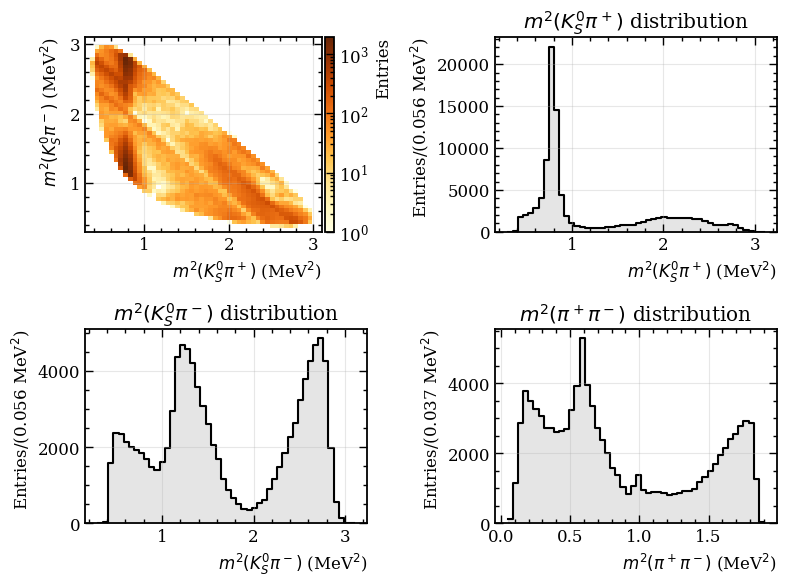

In [15]:
fig, ax= plot_data(toy_sample)

## Loading model from library

Testing the loading of the model from a library

In [16]:
from context import models
from models.d02kspipi import babar2008_model

In [17]:
def babar_model(x):
    return babar2008_model(x, phsp,
        atfi.const(belle_model['rho770_Mass'][0]),
        atfi.const(belle_model['rho770_Width'][0]),
        atfi.const(belle_model['Kstar892_Mass'][0]),
        atfi.const(belle_model['Kstar892_Width'][0]),
        atfi.const(belle_model['Kstartwo1430_Mass'][0]),
        atfi.const(belle_model['Kstartwo1430_Width'][0]),
        atfi.const(belle_model['Kstar1410_Mass'][0]),
        atfi.const(belle_model['Kstar1410_Width'][0]),
        atfi.const(belle_model['Kstar1680_Mass'][0]),
        atfi.const(belle_model['Kstar1680_Width'][0]),
        atfi.const(belle_model['omega_Mass'][0]),
        atfi.const(belle_model['omega_Width'][0]),
        atfi.const(belle_model['ftwo1270_Mass'][0]),
        atfi.const(belle_model['ftwo1270_Width'][0]),
        atfi.const(belle_model['rho1450_Mass'][0]),
        atfi.const(belle_model['rho1450_Width'][0]),
        # LASS
        atfi.const(belle_model['LASS_a'][0]),
        atfi.const(belle_model['LASS_r'][0]),
        atfi.const(1.4617),
        atfi.const(0.2683),
        atfi.const(belle_model['LASS_R'][0]),
        atfi.const(belle_model['LASS_phi_R'][0]),
        atfi.const(belle_model['LASS_F'][0]),
        atfi.const(belle_model['LASS_phi_F'][0]),
        # K matrix model parameters
        atfi.const( [0.651, 1.2036, 1.55817, 1.21, 1.82206] ),
        atfi.const( [ [0.22889, -0.55377, 0, -0.39899, -0.34639],
                        [0.94128, 0.55095, 0, 0.39065, 0.31503],
                        [0.36856, 0.23888, 0.55639, 0.18340, 0.18681],
                        [0.33650, 0.40907, 0.85679, 0.19906, -0.00984],
                        [0.18171, -0.17558, -0.79658, -0.00355, 0.22358]] ),
        atfi.const(-3.92637),
        atfi.const([ [  0.23399,  0.15044, -0.20545,  0.32825,  0.35412],
                   [  0.15044, 0, 0, 0, 0],
                   [ -0.20545, 0, 0, 0, 0],
                   [  0.32825, 0, 0, 0, 0],
                   [  0.35412, 0, 0, 0, 0]]),
        atfi.stack([params[f'Kmatrix_beta{i}'] for i in range(1, 6)]),
        atfi.const(-0.070000000000000),
        atfi.stack([params[f'Kmatrix_f_prod_1{i}'] for i in range(1, 6)]),
        [[mpi,mpi], [mkz, mkz], [mpi], [meta, meta], [meta, metap]])

In [18]:
def toymc_model_babar(x, switches=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0]):#15 * [1]):
    return babar_model(x)(
        switches=switches,
        a1r=atfi.const(1.0),
        a1i=atfi.const(0.0),
        a2r=atfi.real(params['Kstar892minus']),
        a2i=atfi.imaginary(params['Kstar892minus']),
        a3r=atfi.real(params['Kstarzero1430minus']),
        a3i=atfi.imaginary(params['Kstarzero1430minus']),
        a4r=atfi.real(params['Kstartwo1430minus']),
        a4i=atfi.imaginary(params['Kstartwo1430minus']),
        a5r=atfi.real(params['Kstar1410minus']),
        a5i=atfi.imaginary(params['Kstar1410minus']),
        a6r=atfi.real(params['Kstar1680minus']),
        a6i=atfi.imaginary(params['Kstar1680minus']),
        a7r=atfi.real(params['Kstar892plus']),
        a7i=atfi.imaginary(params['Kstar892plus']),
        a8r=atfi.real(params['Kstarzero1430plus']),
        a8i=atfi.imaginary(params['Kstarzero1430plus']),
        a9r=atfi.real(params['Kstartwo1430plus']),
        a9i=atfi.imaginary(params['Kstartwo1430plus']),
        a10r=atfi.real(params['Kstar1410plus']),
        a10i=atfi.imaginary(params['Kstar1410plus']),
        a11r=atfi.real(params['Kstar1680plus']),
        a11i=atfi.imaginary(params['Kstar1680plus']),
        a12r=atfi.real(params['omega']),
        a12i=atfi.imaginary(params['omega']),
        a13r=atfi.real(params['ftwo1270']),
        a13i=atfi.imaginary(params['ftwo1270']),
        a14r=atfi.real(params['rho1450']),
        a14i=atfi.imaginary(params['rho1450']),
    )

In [19]:
ntoys = 100000
toy_sample = tft.run_toymc(
    toymc_model_babar, phsp, ntoys, maximum=1.0e-20, chunk=1000000, components=False
)

  Updating maximum: 1e-20 -> 6990.341489553978. Starting over.
  Chunk 1, size=10541, total length=10541
  Chunk 2, size=10586, total length=21127
  Chunk 3, size=10684, total length=31811
  Chunk 4, size=10481, total length=42292
  Chunk 5, size=10743, total length=53035
  Chunk 6, size=10587, total length=63622
  Chunk 7, size=10572, total length=74194
  Chunk 8, size=10711, total length=84905
  Chunk 9, size=10613, total length=95518
  Chunk 10, size=10615, total length=106133


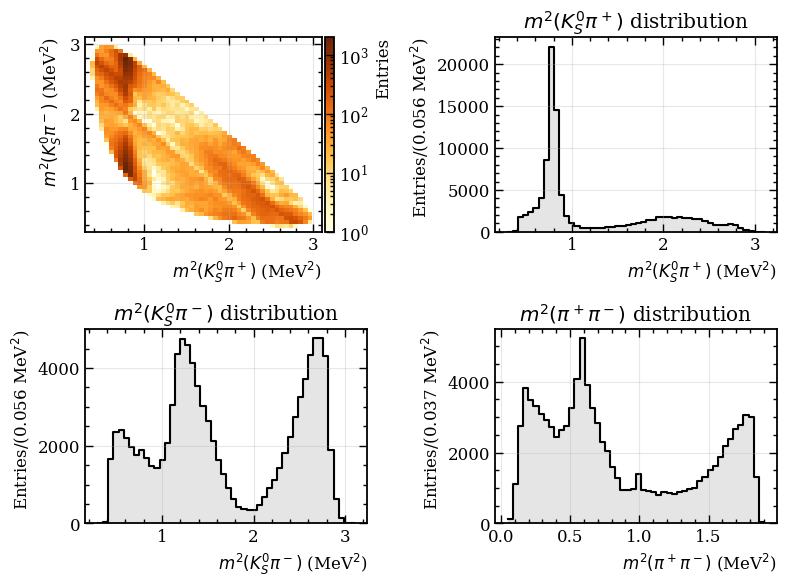

In [20]:
fig, ax= plot_data(toy_sample)

In [22]:
from models.d02kspipi import babar2008_model_amp
def babar_model_amp(x):
    return babar2008_model_amp(x, phsp,
        atfi.const(belle_model['rho770_Mass'][0]),
        atfi.const(belle_model['rho770_Width'][0]),
        atfi.const(belle_model['Kstar892_Mass'][0]),
        atfi.const(belle_model['Kstar892_Width'][0]),
        atfi.const(belle_model['Kstartwo1430_Mass'][0]),
        atfi.const(belle_model['Kstartwo1430_Width'][0]),
        atfi.const(belle_model['Kstar1410_Mass'][0]),
        atfi.const(belle_model['Kstar1410_Width'][0]),
        atfi.const(belle_model['Kstar1680_Mass'][0]),
        atfi.const(belle_model['Kstar1680_Width'][0]),
        atfi.const(belle_model['omega_Mass'][0]),
        atfi.const(belle_model['omega_Width'][0]),
        atfi.const(belle_model['ftwo1270_Mass'][0]),
        atfi.const(belle_model['ftwo1270_Width'][0]),
        atfi.const(belle_model['rho1450_Mass'][0]),
        atfi.const(belle_model['rho1450_Width'][0]),
        # LASS
        atfi.const(belle_model['LASS_a'][0]),
        atfi.const(belle_model['LASS_r'][0]),
        atfi.const(1.4617),
        atfi.const(0.2683),
        atfi.const(belle_model['LASS_R'][0]),
        atfi.const(belle_model['LASS_phi_R'][0]),
        atfi.const(belle_model['LASS_F'][0]),
        atfi.const(belle_model['LASS_phi_F'][0]),
        # K matrix model parameters
        atfi.const( [0.651, 1.2036, 1.55817, 1.21, 1.82206] ),
        atfi.const( [ [0.22889, -0.55377, 0, -0.39899, -0.34639],
                        [0.94128, 0.55095, 0, 0.39065, 0.31503],
                        [0.36856, 0.23888, 0.55639, 0.18340, 0.18681],
                        [0.33650, 0.40907, 0.85679, 0.19906, -0.00984],
                        [0.18171, -0.17558, -0.79658, -0.00355, 0.22358]] ),
        atfi.const(-3.92637),
        atfi.const([ [  0.23399,  0.15044, -0.20545,  0.32825,  0.35412],
                   [  0.15044, 0, 0, 0, 0],
                   [ -0.20545, 0, 0, 0, 0],
                   [  0.32825, 0, 0, 0, 0],
                   [  0.35412, 0, 0, 0, 0]]),
        atfi.stack([params[f'Kmatrix_beta{i}'] for i in range(1, 6)]),
        atfi.const(-0.070000000000000),
        atfi.stack([params[f'Kmatrix_f_prod_1{i}'] for i in range(1, 6)]),
        [[mpi,mpi], [mkz, mkz], [mpi], [meta, meta], [meta, metap]])

def toymc_model_babar_amp(x, switches=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0]):#15 * [1]):
    return babar_model_amp(x)(
        switches=switches,
        a1r=atfi.const(1.0),
        a1i=atfi.const(0.0),
        a2r=atfi.real(params['Kstar892minus']),
        a2i=atfi.imaginary(params['Kstar892minus']),
        a3r=atfi.real(params['Kstarzero1430minus']),
        a3i=atfi.imaginary(params['Kstarzero1430minus']),
        a4r=atfi.real(params['Kstartwo1430minus']),
        a4i=atfi.imaginary(params['Kstartwo1430minus']),
        a5r=atfi.real(params['Kstar1410minus']),
        a5i=atfi.imaginary(params['Kstar1410minus']),
        a6r=atfi.real(params['Kstar1680minus']),
        a6i=atfi.imaginary(params['Kstar1680minus']),
        a7r=atfi.real(params['Kstar892plus']),
        a7i=atfi.imaginary(params['Kstar892plus']),
        a8r=atfi.real(params['Kstarzero1430plus']),
        a8i=atfi.imaginary(params['Kstarzero1430plus']),
        a9r=atfi.real(params['Kstartwo1430plus']),
        a9i=atfi.imaginary(params['Kstartwo1430plus']),
        a10r=atfi.real(params['Kstar1410plus']),
        a10i=atfi.imaginary(params['Kstar1410plus']),
        a11r=atfi.real(params['Kstar1680plus']),
        a11i=atfi.imaginary(params['Kstar1680plus']),
        a12r=atfi.real(params['omega']),
        a12i=atfi.imaginary(params['omega']),
        a13r=atfi.real(params['ftwo1270']),
        a13i=atfi.imaginary(params['ftwo1270']),
        a14r=atfi.real(params['rho1450']),
        a14i=atfi.imaginary(params['rho1450']),
    )
toymc_model_babar_amp(atfi.const(toy_sample[:1]))

<tf.Tensor: shape=(1,), dtype=complex128, numpy=array([-31.19798277-34.75638141j])>

In [28]:
def m0prime(phsp, m2pipi):
    m0 = atfi.sqrt(m2pipi)
    return atfi.acos( 2.0 * (m0 - atfi.sqrt(phsp.minac)) / (atfi.sqrt(phsp.maxac)- atfi.sqrt(phsp.minac)) - 1.0 ) / atfi.pi()

def thprime(costh):
    return atfi.acos(costh) / atfi.pi()

In [31]:
print( phsp.minac, phsp.maxac )
m0p = m0prime(phsp, phsp.m2ac(toy_sample[:1]))
thp = thprime(phsp.cos_helicity_ac(toy_sample[:1]))
print(m0p, thp)
print(phsp.m_prime_ac(toy_sample[:1]), phsp.theta_prime_ac(toy_sample[:1]))
print(phsp.from_square_dalitz_plot(m0p, thp))
print(toy_sample[:1])

tf.Tensor(0.07791957505900841, shape=(), dtype=float64) tf.Tensor(1.8693151384409996, shape=(), dtype=float64)
tf.Tensor([0.53278887], shape=(1,), dtype=float64) tf.Tensor([0.2397789], shape=(1,), dtype=float64)
tf.Tensor([0.53278887], shape=(1,), dtype=float64) tf.Tensor([0.2397789], shape=(1,), dtype=float64)
tf.Tensor([[0.7287477  2.44679618]], shape=(1, 2), dtype=float64)
tf.Tensor([[0.7287477  2.44679618]], shape=(1, 2), dtype=float64)


In [ ]:
range_t = (0.5, 8)
range_m2pipi = ( phsp.minac, phsp.maxac )
range_cospipi = (-1, 1)



In [25]:
phsp.minac - 4.0*mpi**2

<tf.Tensor: shape=(), dtype=float64, numpy=0.0>

In [ ]:
kmatrix_amp_np2 = np.array([amplitude_KMatrix(s, g_poles.numpy(), m_poles.numpy(), fij.numpy(), b_poles.numpy(), fprod1.numpy(),
					  s_scatt=-3.92637, sa=1.0, sa_0=-0.15, s0prod=-0.07) for s in m2ac.numpy()])

/tmp/ipykernel_766367/2479737573.py:11: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(1.0 - (16.0 * mpi * mpi / s)),
